In [1]:
import os
os.chdir('../..')
from config.config import load_configs
config = load_configs()
print(os.getcwd())

/workspace/LLaSA


In [2]:
os.chdir('model/segmentation')
from segmentation_generator import SegmentationGenerator
os.chdir('../..')
seg_generator = SegmentationGenerator(config)




sam2_cfg path:  model/segmentation/sam2_configs


In [12]:
import json
import os
import numpy as np
from tqdm import tqdm


file_path = 'dataset/A2D/output_video_info.json'
video_path_base = 'dataset/A2D/clips320jpeg'

with open(file_path, 'r') as file:
    data = json.load(file)

for idx, (key, value) in enumerate(tqdm(data.items(), total=len(data), desc="Processing")):
    video = value['video']
    bbox_frame = value['bbox_frame']
    bbox = np.float32(value['bbox'])
    caption = value['caption']

    
    video_path = os.path.join(video_path_base, video)

    print(video_path, bbox_frame, bbox, caption)

    video_segments, result, out_frame_idx, out_obj_ids, out_mask_logits = seg_generator(video_path, bbox_frame, bbox, debug=True, intermediate_result=True)

    print(result.shape)
    break


Processing:   0%|          | 0/6244 [00:00<?, ?it/s]

dataset/A2D/clips320jpeg/--h5fAKYurM 30 [214.33125   92.888885 303.525    148.      ] the pigeon is limping


frame loading (JPEG): 100%|██████████| 181/181 [00:04<00:00, 36.61it/s]
/workspace/LLaSA/model/segmentation/sam2/sam2_video_predictor.py:873: UserWarning: cannot import name '_C' from 'sam2' (/workspace/LLaSA/model/segmentation/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
Processing:   0%|          | 0/6244 [00:39<?, ?it/s]

torch.Size([1, 4096, 256])


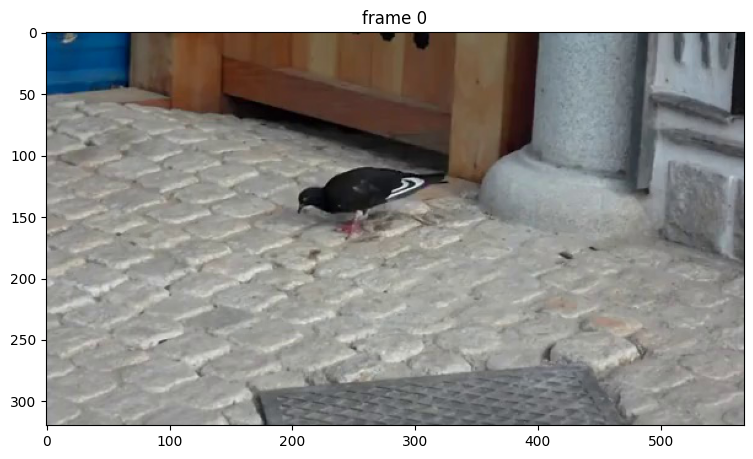

In [13]:
import matplotlib.pyplot as plt
from PIL import Image
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "/workspace/LLaSA/dataset/A2D/clips320jpeg/--h5fAKYurM"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

In [14]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

In [15]:
video_segments[30]

{1: array([[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]])}

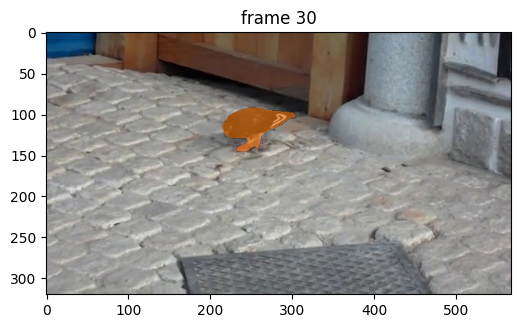

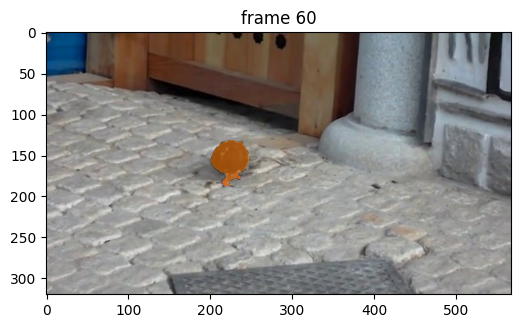

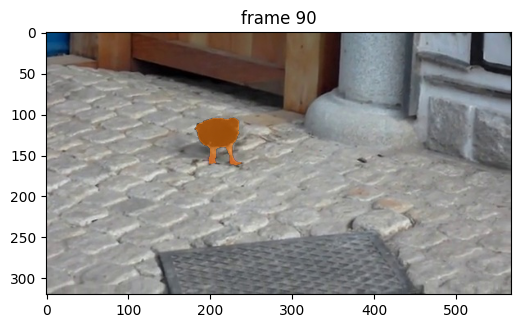

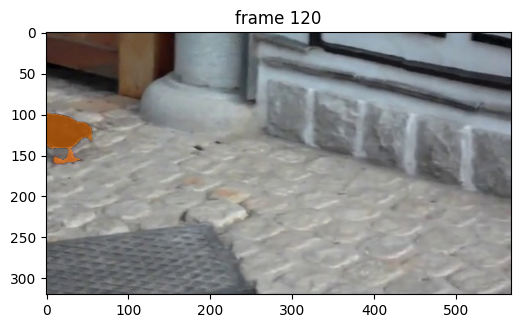

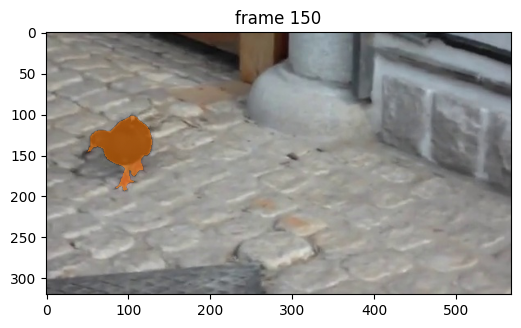

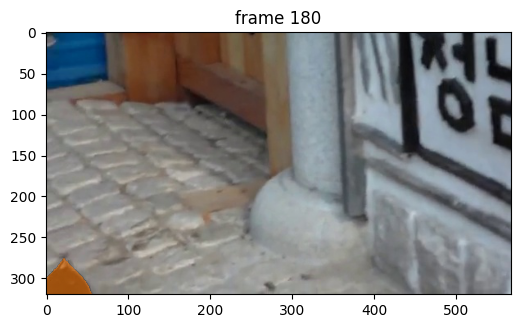

In [16]:
# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(30, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)